# Kode til oppgaven

Plasseres først så det ikke blir noe tull med å rendre ipynb'en til pdf.

## Kode

### Pakker

In [1]:
# Pakker
!pip install pyjstat

import json
import pandas as pd
import requests
from pyjstat import pyjstat
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import seaborn as sns
import numpy as np
import sympy as sy
import statsmodels.api as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyjstat: filename=pyjstat-2.4.0-py3-none-any.whl size=22762 sha256=c3fb1105e93e4cf8a181835300ab66690f1d1276bc844ca0c8f00e5d4c2eff46
  Stored in directory: /root/.cache/pip/wheels/14/22/83/5d10b2446d66e85756b014a01e987a950124f15e39ff87328e
Successfully built pyjstat


### Oppgave 1

#### Dataframes

#### KPI

In [2]:
# KPI-df
# Koden er hentet fra kursrepoet til sok-1006

# Henter KPI-tabell med en JSON-spørring, dette er en tabell hvor 2015 = 100
# Gjør dette for å kunne konvertere omsetningen fra de andre tabellene til realpriser
# https://www.ssb.no/priser-og-prisindekser/nytt-referansear-2015-100-i-konsumprisindeksen-kpi

# Lim in PostUrl som spørringen skal postes mot
postUrl = "https://data.ssb.no/api/v0/no/table/03013/"

# spørring fra SSB
# I første instans laster jeg inn all dataen, selv om jeg bare opererer med tall fra 2000 og ut

apiQuery = {
  "query": [
    {
      "code": "Konsumgrp",
      "selection": {
        "filter": "vs:CoiCop2016niva1",
        "values": []
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "KpiIndMnd"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


# Funksjon for å konvertere uttrekket til 2 dataframes, tar 2 paramtre (SSB)

def apiToDataframe(postUrl, query):

    # postUrl som spørringen skal postes mot
    # Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

    res = requests.post(postUrl, json=query)
    # legger resultat i ds. DS har i tillegg en del metadata
    ds = pyjstat.Dataset.read(res.text)
    # skriver resultatet til to dataframes
    # først dataframe med tekst
    df = ds.write('dataframe')
    # deretter dataframe med koder
    df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
    return df, df_id, ds


df, df_id, ds = apiToDataframe(postUrl, apiQuery)


# gir kolonnen for KPI navnet KPI for å gjøre det lettere å holde oversikt

df.rename(columns={'value': 'KPI(2015=100)'}, inplace=True)

#Omformer månedlig til årlig KPI for å enklere matche andre datasettene jeg har

# Henter ut årsverdien
df['år'] = df['måned'].str[:4]

# Her lager jeg en enkel funksjon for å finne gjennomsnittsverdien for hvert år
aggregation_functions = {
    'KPI(2015=100)': 'mean'
}

# For å gjøre det enklere å bruke den flere ganger og holde orden i df'ene gir jeg den nytt navn
kpi_df = df

# Group by ´år´og bruker funksjonen
kpi_df = df.groupby('år').agg(aggregation_functions).reset_index()


#### ii) Omsetning hele næringen

In [3]:
# Omsetning i varhandel på 2-siffer nivå
# Bruker samme type API-spørring fra samme repo hver gang

# Lim in PostUrl som spørringen skal postes mot
postUrl = "https://data.ssb.no/api/v0/no/table/07312/"

# spørring fra SSB

apiQuery = {
  "query": [
    {
      "code": "NACE2007",
      "selection": {
        "filter": "vs:NACE2007vroms2",
        "values": [
          "47"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


# Funksjon for å konvertere uttrekket til 2 dataframes, tar 2 paramtre (SSB)

def apiToDataframe(postUrl, query):

    # postUrl som spørringen skal postes mot
    # Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

    res = requests.post(postUrl, json=query)
    # legger resultat i ds. DS har i tillegg en del metadata
    ds = pyjstat.Dataset.read(res.text)
    # skriver resultatet til to dataframes
    # først dataframe med tekst
    df = ds.write('dataframe')
    # deretter dataframe med koder
    df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
    return df, df_id, ds


df, df_id, ds = apiToDataframe(postUrl, apiQuery)

# gir kolonnen for Omsetning et bedre navn for å gjøre det lettere å holde oversikt

df.rename(columns={'value': 'Omsetning (mill.kr)'}, inplace=True)

# Henter ut årsverdien
df['år'] = df['termin'].str[:4]

# Her lager jeg en enkel funksjon for å finne den aggregerte omsetningen for hvert år
aggregation_functions = {
    'Omsetning (mill.kr)': 'sum'
}

# For å gjøre det enklere å bruke den flere ganger og holde orden i df'ene gir jeg den nytt navn
omsetning_47_df = df

# Group by ´år´og bruker funksjonen
omsetning_47_df = df.groupby('år').agg(aggregation_functions).reset_index()

#merger inn kpi_df for å kunne lage en kolonne med realverdier
omsetning_47_df = omsetning_47_df.merge(kpi_df, left_on='år', right_on='år', how='left')

# Lager en ny kolonne med realomsetning
omsetning_47_df['Realomsetning (mill.kr)(2015=100)'] = omsetning_47_df['Omsetning (mill.kr)'] * (100 /omsetning_47_df['KPI(2015=100)'])

omsetning_47_df['Realomsetning (mill.kr)(2015=100)'] = omsetning_47_df['Realomsetning (mill.kr)(2015=100)'].astype(int) # sikre hele tall

#### ii) Sysselsatte i detaljnæringen

In [4]:
# Omsetning i varhandel på 2-siffer nivå

# Lim in PostUrl som spørringen skal postes mot
postUrl = "https://data.ssb.no/api/v0/no/table/12910/"

# spørring fra SSB

apiQuery = {
  "query": [
    {
      "code": "NACE2007",
      "selection": {
        "filter": "vs:NACE2007StrNaring",
        "values": [
          "47"
        ]
      }
    },
    {
      "code": "Enhet",
      "selection": {
        "filter": "item",
        "values": [
          "31"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Enheter",
          "Sysselsatte",
          "Arsverk",
          "Oms"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


# Funksjon for å konvertere uttrekket til 2 dataframes, tar 2 paramtre (SSB)

def apiToDataframe(postUrl, query):

    # postUrl som spørringen skal postes mot
    # Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

    res = requests.post(postUrl, json=query)
    # legger resultat i ds. DS har i tillegg en del metadata
    ds = pyjstat.Dataset.read(res.text)
    # skriver resultatet til to dataframes
    # først dataframe med tekst
    df = ds.write('dataframe')
    # deretter dataframe med koder
    df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
    return df, df_id, ds


df, df_id, ds = apiToDataframe(postUrl, apiQuery)
df_12910 = df

df_12910 = pd.pivot_table(df_12910, values="value", index=["år"], columns=["statistikkvariabel"])

#merger inn kpi_df for å kunne lage en kolonne med realverdier
df_12910 = df_12910.merge(kpi_df, left_on='år', right_on='år', how='left')

# Lager en ny kolonne med realomsetning
df_12910['Realomsetning (mill.kr)(2015=100)'] = df_12910['Omsetning (mill. kr)'] * (100 /df_12910['KPI(2015=100)'])

df_12910['Realomsetning (mill.kr)(2015=100)'] = df_12910['Realomsetning (mill.kr)(2015=100)'].astype(int) # sikre hele tall

#### ii) Sysselsatte hele norge

In [5]:
# Omsetning i varhandel på 2-siffer nivå

# Lim in PostUrl som spørringen skal postes mot
postUrl = "https://data.ssb.no/api/v0/no/table/12910/"

# spørring fra SSB

apiQuery = {
  "query": [
    {
      "code": "NACE2007",
      "selection": {
        "filter": "vs:NACE2007StrAggr",
        "values": [
          "B-J+L-N+S"
        ]
      }
    },
    {
      "code": "Enhet",
      "selection": {
        "filter": "item",
        "values": [
          "31"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Sysselsatte"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


# Funksjon for å konvertere uttrekket til 2 dataframes, tar 2 paramtre (SSB)

def apiToDataframe(postUrl, query):

    # postUrl som spørringen skal postes mot
    # Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

    res = requests.post(postUrl, json=query)
    # legger resultat i ds. DS har i tillegg en del metadata
    ds = pyjstat.Dataset.read(res.text)
    # skriver resultatet til to dataframes
    # først dataframe med tekst
    df = ds.write('dataframe')
    # deretter dataframe med koder
    df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
    return df, df_id, ds


df, df_id, ds = apiToDataframe(postUrl, apiQuery)
df_12910_hele = df

#### iiiA) Detaljhandelen, spesifikke næringer

In [6]:
# Omsetning i varhandel på 4-siffer nivå

# Lim in PostUrl som spørringen skal postes mot
postUrl = "https://data.ssb.no/api/v0/no/table/07313/"

# spørring fra SSB

apiQuery = {
  "query": [
    {
      "code": "NACE2007",
      "selection": {
        "filter": "vs:NACE2007vroms4",
        "values": [
          "47.29",
          "47.65",
          "47.71",
          "47.75",
          "47.79"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


# Funksjon for å konvertere uttrekket til 2 dataframes, tar 2 paramtre (SSB)

def apiToDataframe(postUrl, query):

    # postUrl som spørringen skal postes mot
    # Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

    res = requests.post(postUrl, json=query)
    # legger resultat i ds. DS har i tillegg en del metadata
    ds = pyjstat.Dataset.read(res.text)
    # skriver resultatet til to dataframes
    # først dataframe med tekst
    df = ds.write('dataframe')
    # deretter dataframe med koder
    df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
    return df, df_id, ds


df, df_id, ds = apiToDataframe(postUrl, apiQuery)
Omsetning_07313 = df

Omsetning_07313.rename(columns={'value': 'Omsetning (mill.kr)'}, inplace=True)

#merger inn kpi_df for å kunne lage en kolonne med realverdier
Omsetning_07313 = Omsetning_07313.merge(kpi_df, left_on='år', right_on='år', how='left')

# Lager en ny kolonne med realomsetning
Omsetning_07313['Realomsetning (mill.kr)(2015=100)'] = Omsetning_07313['Omsetning (mill.kr)'] * (100 /Omsetning_07313['KPI(2015=100)'])

Omsetning_07313['Realomsetning (mill.kr)(2015=100)'] = Omsetning_07313['Realomsetning (mill.kr)(2015=100)'].astype(int) # sikre hele tall

#### iiiB) Detaljhandelen, fokus på netthandel

In [7]:
# Omsetning i varhandel på 2-siffer nivå

# Lim in PostUrl som spørringen skal postes mot
postUrl = "https://data.ssb.no/api/v0/no/table/07313/"

# spørring fra SSB

apiQuery = {
  "query": [
    {
      "code": "NACE2007",
      "selection": {
        "filter": "vs:NACE2007vroms4",
        "values": [
          "47.91"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


# Funksjon for å konvertere uttrekket til 2 dataframes, tar 2 paramtre (SSB)

def apiToDataframe(postUrl, query):

    # postUrl som spørringen skal postes mot
    # Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

    res = requests.post(postUrl, json=query)
    # legger resultat i ds. DS har i tillegg en del metadata
    ds = pyjstat.Dataset.read(res.text)
    # skriver resultatet til to dataframes
    # først dataframe med tekst
    df = ds.write('dataframe')
    # deretter dataframe med koder
    df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
    return df, df_id, ds


df, df_id, ds = apiToDataframe(postUrl, apiQuery)
Omsetning_07313_nett = df

Omsetning_07313_nett.rename(columns={'value': 'Omsetning (mill.kr)'}, inplace=True)

#merger inn kpi_df for å kunne lage en kolonne med realverdier
Omsetning_07313_nett = Omsetning_07313_nett.merge(kpi_df, left_on='år', right_on='år', how='left')

# Lager en ny kolonne med realomsetning
Omsetning_07313_nett['Realomsetning (mill.kr)(2015=100)'] = Omsetning_07313_nett['Omsetning (mill.kr)'] * (100 /Omsetning_07313['KPI(2015=100)'])

Omsetning_07313_nett['Realomsetning (mill.kr)(2015=100)'] = Omsetning_07313_nett['Realomsetning (mill.kr)(2015=100)'].astype(int) # sikre hele tall

#### Grafer

#### ii) Realomsetning i mill.kr

In [8]:
# Definerer en graf som jeg muligens kan bruke igjen
def plot_series(series, series_name, series_index=0, title="", subtitle="", undertext=""):
# Gjør år om til integers da den er lastet inn som 'character'
    series['år'] = series['år'].astype(int)
# Filtrerer slik at jeg bare ser 2008 til 2023 i tilfelle tabellen blir oppdatert før denne levers inn
    filtered_series = series[(series['år'] >= 2008) & (series['år'] <= 2023)]
# Henter en fargepalett fra seaborn
    palette = list(sns.palettes.mpl_palette('Dark2'))
# Definerer hva som skal være x og y
    xs = filtered_series['år']
    ys = filtered_series['Realomsetning (mill.kr)(2015=100)']

# Lager en ny plot
    fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
# Sier hvordan axene og slikt skal være
    ax.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

# Fjerner "border" for å få en litt mer "clean" look
    sns.despine(fig=fig, ax=ax)
# Gir navn til axene
    ax.set_xlabel('År')
    ax.set_ylabel('Realomsetning (mill.2015-kr)')
# passer på at alle årene vises
    ax.set_xticks(range(2008, 2024))

# Legger til tittel, og undertekst
    if title:
        fig.suptitle(title, fontsize=16)
    if subtitle:
        plt.title(subtitle, fontsize=12)
    if undertext:
        plt.figtext(0.1, -0.1, undertext, wrap=True, horizontalalignment='center', fontsize=10)

    plt.show()
#Passer på at den er organisert etter år i stigende rekkefølge
df_sorted1 = omsetning_47_df.sort_values('år', ascending=True)


#### ii) Sysselsetting Detaljhandelen vs Resten

In [9]:
#Lager en graf med interaktive kakediegram
def create_pie_charts(df_retail, df_norway, years):
    # Merger sammen to dataframes fordi jeg har lastet inn en for bare detalj og en for alle sysselsatte
    df_merged = pd.merge(df_retail, df_norway, on='år', suffixes=('_detalj', '_norge'))

    # Kalkulerer hvor mange som ikke jobber i detaljnæringen
    df_merged['non_retail'] = df_merged['value'] - df_merged['Sysselsatte']

    # For hvert år jeg velger å inkludere lages et nytt omrpde for graf
    fig = sp.make_subplots(
        rows=1, cols=len(years),
        subplot_titles=[f'{year}' for year in years],
        specs=[[{'type': 'domain'} for _ in years]]
    )

    #Definerer fargene
    colors = ['#ff9999', '#66b3ff']

    # Lager kakediagrammene
    for i, year in enumerate(years):
        data = df_merged[df_merged['år'] == year]
        labels = ['Detaljhandel', 'Andre Næringer']
        values = [data['Sysselsatte'].values[0], data['non_retail'].values[0]]

        pie_fig = px.pie(
            values=values,
            names=labels,
            hole=0
        )

        pie_fig.update_traces(
            hoverinfo="percent+value",
            textinfo="percent",
            marker=dict(colors=colors)
        )

        # Putter kakediagrammene i det tidligere definerte området
        fig.add_trace(pie_fig.data[0], row=1, col=i+1)

    # Gjør at de kommer ved siden av hverandre
    fig.update_layout(
        title_text="Fig.2 Ansatte i Detaljnæringen mot resten av Norge 2017 og 2022, K: SSB tabell 12910",
        showlegend=True,
        legend=dict(
            x=0.5,
            y=-0.1,
            xanchor='center',
            orientation='h'
        )
    )

    fig.show()

# Legger denne inn her siden jeg ikke endte opp med å bruke kakediagram-funksjonen flere steder
df_retail = pd.DataFrame(df_12910)
df_norway = pd.DataFrame(df_12910_hele)

# Definerer hvilke år jeg vil inkludere, ble veldig kludrete med flere så jeg velger første og siste år i dataframen
selected_years = [df_retail['år'].min(), df_retail['år'].max()]


In [10]:
# Dette var et annet alternativ for kakediagram jeg vurderte å bruke
# Create DataFrames
df_retail = pd.DataFrame(df_12910)
df_norway = pd.DataFrame(df_12910_hele)

# Merge DataFrames on 'år'
df_merged = pd.merge(df_retail, df_norway, on='år', suffixes=('_detalj', '_norge'))

# Calculate the number of non-retail employees
df_merged['non_retail'] = df_merged['value'] - df_merged['Sysselsatte']

# Create an interactive pie chart for each year
for year in df_merged['år']:
    data = df_merged[df_merged['år'] == year]
    labels = ['Detaljhandel', 'Andre Næringer']
    values = [data['Sysselsatte'].values[0], data['non_retail'].values[0]]

    fig = px.pie(
        values=values,
        names=labels,
        title=f'Ansatte i Detaljnæringen i {year}',
        hole=0.3
    )

    fig.update_traces(
        hoverinfo="percent+value",
        textinfo="percent",
        marker=dict(colors=['#ff9999','#66b3ff'])
    )

#### iiiA) Detaljnæringen utvalgte markeder

In [11]:
# Definerer en funksjon for å lage et plott med flere linjer
def plot_multiple_series(df, industries, title="", xlabel="År", ylabel="Realomsetning (mill.kr)(2015=100)", legend_title="Næring (SN2007)"):
# Gjør år om til integers da den er lastet inn som 'character'
    df['år'] = df['år'].astype(int)

# Filtrerer slik at jeg bare ser 2008 til 2023 i tilfelle tabellen blir oppdatert før denne levers inn
    filtered_df = df[(df['år'] >= 2008) & (df['år'] <= 2023)]

    plt.figure(figsize=(12, 8))
# Definerer hver linje i diagrammet
    for industry in industries:
        industry_data = filtered_df[filtered_df["næring (SN2007)"] == industry]
        plt.plot(industry_data["år"], industry_data["Realomsetning (mill.kr)(2015=100)"], marker='o', label=industry)

#Sier at plottet skal inkludere labels på x og y og tittel
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title=legend_title)
    plt.grid(True)

# passer på at alle årene vises
    plt.xticks(range(2008, 2024))

#Viser plottet
    plt.show()

# Definerer industrinavnene i tilfallet det blir noe kluss å importere direkte
industries = [
    "Butikkhandel med spill og leker",
    "Butikkhandel med klær",
    "Butikkhandel med kosmetikk og toalettartikler",
    "Butikkhandel med brukte varer"
]


#### iiiB) Detaljnæringen netthandel

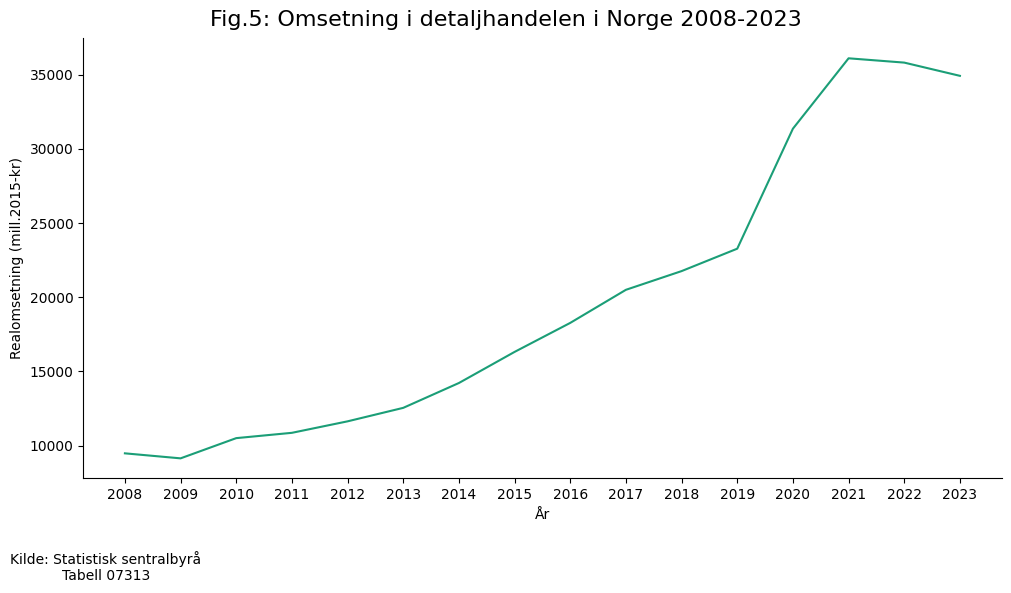

In [12]:
df_sorted5 = Omsetning_07313_nett.sort_values('år', ascending=True)
plot_series(df_sorted5, 'Omsetning i detaljhandelen i Norge 2008-2023',
            title="Fig.5: Omsetning i detaljhandelen i Norge 2008-2023",
            undertext="Kilde: Statistisk sentralbyrå Tabell 07313")

### Oppgave 2

#### Dataframes

In [13]:
# Henter API med samme kode som tidligere
# Lim in PostUrl som spørringen skal postes mot
postUrl = "https://data.ssb.no/api/v0/no/table/12910/"

# spørring fra SSB

apiQuery = {
  "query": [
    {
      "code": "NACE2007",
      "selection": {
        "filter": "vs:NACE2007StrNaringUndGr",
        "values": [
          "47.111",
          "47.112",
          "47.190",
          "47.210",
          "47.220",
          "47.230",
          "47.241",
          "47.242",
          "47.251",
          "47.259",
          "47.260",
          "47.291",
          "47.292",
          "47.299",
          "47.300",
          "47.410",
          "47.420",
          "47.430",
          "47.510",
          "47.521",
          "47.522",
          "47.523",
          "47.524",
          "47.529",
          "47.531",
          "47.532",
          "47.533",
          "47.540",
          "47.591",
          "47.592",
          "47.593",
          "47.594",
          "47.599",
          "47.610",
          "47.620",
          "47.630",
          "47.641",
          "47.642",
          "47.650",
          "47.710",
          "47.721",
          "47.722",
          "47.730",
          "47.740",
          "47.750",
          "47.761",
          "47.762",
          "47.771",
          "47.772",
          "47.781",
          "47.782",
          "47.789",
          "47.791",
          "47.792",
          "47.799",
          "47.810",
          "47.820",
          "47.890",
          "47.911",
          "47.912",
          "47.913",
          "47.914",
          "47.915",
          "47.916",
          "47.917",
          "47.919",
          "47.990"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Produksjonsverdi",
          "Lonnskost",
          "BruttoInvesteringer"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2022"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


# Funksjon for å konvertere uttrekket til 2 dataframes, tar 2 paramtre (SSB)

def apiToDataframe(postUrl, query):

    # postUrl som spørringen skal postes mot
    # Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

    res = requests.post(postUrl, json=query)
    # legger resultat i ds. DS har i tillegg en del metadata
    ds = pyjstat.Dataset.read(res.text)
    # skriver resultatet til to dataframes
    # først dataframe med tekst
    df = ds.write('dataframe')
    # deretter dataframe med koder
    df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
    return df, df_id, ds


df, df_id, ds = apiToDataframe(postUrl, apiQuery)

# slå sammen verdier for foretak og bedrift

df_sum = df.groupby(['næring (SN2007)', 'statistikkvariabel']).sum().reset_index()

# dropp kolonner

df_sum = df_sum.drop(columns=['foretak/bedrift', 'år'])

# pivot

df_pivot = df_sum.pivot_table(index='næring (SN2007)', columns='statistikkvariabel', values='value')

# lag en kopi av datasettet

data = df_pivot.copy()

# fjern rader med verdier lik 0

data = data.drop(data[data.eq(0).any(axis=1)].index)

#vis datasettet

oppg_2_df = data

#### Funksjoner og utregninger

In [14]:
# Kode hantet og adaptert fra Github-repo
#1)
# definer nye symboler
N, Z, K, a, b = sy.symbols('N Z K a b', positive=True, real=True)

# definer produktfn
def prod_cd(Z, N,K,a,b):
    return Z*(N**a)*(K**b)

# finn "overskudd" fra en fordobling av innsats i forhold til dobbel så mye produksjon
# NB begge innsatsfaktorene fordobles

overskudd_cd=prod_cd(Z,2*N,2*K,a,b)-2*prod_cd(Z, N,K,a,b)
sy.simplify(overskudd_cd)

def prod_4(N,K,a,b,Z):
    return Z*N**a*K**b

# ta log av produktfunksjonen log(x)=....
prod_log=sy.log(prod_4(N,K,a,b,Z))
prod_log

# som ikke er på ønsket form. La oss utvide uttrykket via sy.expand()
sy.expand(prod_log)

a*log(N) + b*log(K) + log(Z)

In [15]:
# Del 2 av kode hentet fra github-repo
#Definerer nye kolonner med logaritmerte verdier
oppg_2_df['log_K'] = np.log(oppg_2_df['Bruttoinvesteringer (mill. kr)'])
oppg_2_df['log_N'] = np.log(oppg_2_df['Lønnskostnader (mill. kr)'])
oppg_2_df['log_x'] = np.log(oppg_2_df['Produksjonsverdi (mill. kr)'])


X = oppg_2_df[['log_K', 'log_N']]
X = sm.add_constant(X)  # Legger til konstant
y = oppg_2_df['log_x']

#Kjører regresjonsmodell
model = sm.OLS(y, X).fit()
model_summary = model.summary()
print(model_summary)

#Henter data og omdanner Z fra logaritmert til normal
log_Z = model.params['const']
Z = np.exp(log_Z)
a = model.params['log_N']
b = model.params['log_K']
print(model_summary)
print(f"Z: {round(Z,2)}")
print(f"a: {round(a,2)}")
print(f"b: {round(b,2)}")

                            OLS Regression Results                            
Dep. Variable:                  log_x   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     522.2
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           8.16e-38
Time:                        15:59:36   Log-Likelihood:                -27.062
No. Observations:                  61   AIC:                             60.12
Df Residuals:                      58   BIC:                             66.46
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5837      0.290      5.465      0.0

### Oppgave 3

#### Funksjonsuttrykk

##### Finne K_0

In [16]:
# Finner gjennomsnittelig ved å ta gjennomsnittet av 'Bruttoinvesteringer (mill. kr)'
K0 = round(oppg_2_df['Bruttoinvesteringer (mill. kr)'].mean(), 2)
print(K0)

271.27


#### Graf

##### iii) Bruk ditt svar til ii) for å tegne bedriftens tilbudskurve i en figur. Forklar figuren nøye.

In [17]:
def plot_cost_curves_før(a, Z, K0, b):
    w = 287
    L = w * (1 / (Z * K0**b))**(1/a)
# Definer grensekostnadsfunksjonen
    def MC(y):
        return (L / a) * y**(1/a - 1)

# Definer gjennomsnittlig variabel kostnadsfunksjon (AVC) og gjennomsnittlig total kostnadsfunksjon (ATC)

    def AVC(y):
        return L * y**(1/a - 1)

    def ATC(y):
        return AVC(y) + K0 / y

# Lag en rekke med produksjonsnivåer
    y = np.linspace(0.1, 1000, 1000) # Unnga y=0 for å unngå deling på null
# Beregn MC, AVC og ATC verdier
    mc_values = MC(y)
    atc_values = ATC(y)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y, mc_values, label='Grensekostnad (MC)', color='aqua')
    plt.plot(y, atc_values, label='Gjennomsnittlig total kostnad (ATC)', color='lawngreen')

    # Identifisere og highlighter tilbudskurven (delen av MC over AVC)
    supply_curve_y_before = y[mc_values > atc_values]
    supply_curve_MC_before = mc_values[mc_values > atc_values]

    # Plotter tilbudskurvene
    plt.plot(supply_curve_y_before, supply_curve_MC_before, label='Tilbudskurve', color='tomato')

    plt.xlabel('Kvantum (y)')
    plt.ylabel('Kostnad')
    plt.title('Kostnadskurver (MC, AVC, ATC)')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 100)
    plt.xlim(0, 1000)

##### iv) Anta at lønnsoppgjøret gir arbeidere i "Helt midt på treet" en lønnsøkning på 5%.

In [18]:
def plot_cost_curves_etter(a, Z, K0, b):
    w = 287
    w2 = w * 1.05
    L = w * (1 / (Z * K0**b))**(1/a)
    L2 = w2 * (1 / (Z * K0**b))**(1/a)
# Definer grensekostnadsfunksjonen
    def MC(y):
        return (L / a) * y**(1/a - 1)


    def MC2(y):
        return (L2 / a) * y**(1/a - 1)

# Definer gjennomsnittlig variabel kostnadsfunksjon (AVC) og gjennomsnittlig total kostnadsfunksjon (ATC)

    def AVC(y):
        return L * y**(1/a - 1)

    def ATC(y):
        return AVC(y) + K0 / y

    def AVC2(y):
        return L2 * y**(1/a - 1)

    def ATC2(y):
        return AVC2(y) + K0 / y
# Lag en rekke med produksjonsnivåer
    y = np.linspace(0.1, 1000, 1000) # Unnga y=0 for å unngå deling på null
# Beregn MC, AVC og ATC verdier
    mc_values = MC(y)
    atc_values = ATC(y)
    mc2_values = MC2(y)
    atc2_values = ATC2(y)
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y, mc_values, label='Grensekostnad (MC)', color='aqua')
    plt.plot(y, mc2_values, label='Grensekostnad etter lønnsøkning (MC)',  linestyle='-.',color='blue')
    plt.plot(y, atc_values, label='Gjennomsnittlig total kostnad (ATC)', color='lawngreen')
    plt.plot(y, atc2_values, label='Gjennomsnittlig total kostnad etter lønnsøkning (ATC)', linestyle='-.', color='green')

    # Identifisere og highlighter tilbudskurven (delen av MC over AVC)
    supply_curve_y_before = y[mc_values > atc_values]
    supply_curve_MC_before = mc_values[mc_values > atc_values]
    supply_curve_y_after = y[mc2_values > atc2_values]
    supply_curve_MC_after = mc2_values[mc2_values > atc2_values]
    # Plotter tilbudskurvene
    plt.plot(supply_curve_y_before, supply_curve_MC_before, label='Tilbudskurve - før lønnsøkning', color='tomato')
    plt.plot(supply_curve_y_after, supply_curve_MC_after, label='Tilbudskurve - etter lønnsøkning', color='red')

    plt.xlabel('Kvantum (y)')
    plt.ylabel('Kostnad')
    plt.title('Kostnadskurver (MC, AVC, ATC) før og etter en lønnsøkning')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 100)
    plt.xlim(0, 1000)

# Mappeoppgave 2
## SOK-1006 Mikroøkonomi: Økonomisk adferd, markeder og priser

Kand.nr. 42

# Oppgave 1 - Kartlegging av detaljhandel i Norge

I denne oppgaven skal jeg definere og så kartlegge utviklingen av detaljhandelen i Norge. Jeg skal se på både oversiktelig omsetning og sysselsetting for hele næringen, for så å peile meg inn på et par produkter i tillegg til netthandel og se hvordan disse har utviklet seg over tid.

Jeg forventer å se en dreining mot netthandel, men er interessert i å se på hvordan koronatiltakene påvirket næringen, og forventer å se en større endring i handelsmønster både under og etter koronakrisen. Dette både som en konsekvens av regjeringens tiltak for å forhindre spredning (som krav om nedstegning av fysiske butikker), men også på grunn av de, for mange, økonomisk usikre tidene som har kommet i etterkant.

## i) Gi en definisjon av detaljhandelen i Norge.

Detaljhandel er en næringsinndeling som inneholder alt av virksomheter som driver salg av varer (nye og/eller brukte) til private husholdninger i eget navn og for egen regning. Eksempler på detaljhandel kan være: salg av mat, drikke, klær, sko, elektriske husholdningsapparater, møbler, byggevarer med mer. Det kan foregå enten fra fast utsalgssted, mobilt utsalgssted, torgplass eller per internett/postordre.

I Norge har detaljnæringen gjennomgått betydelige endringer de siste årene, sterkt påvirket av pandemien. Mens noen endringer har skapt nye muligheter og økt verdiskaping, har andre skapt utfordringer med kostnadspress og behov for rask tilpasning.

##  ii) Finn data hos Statistisk sentralbyrå som beskriver utviklingen av detaljhandelen i Norge.

#### Omsetningen i detaljhandelen

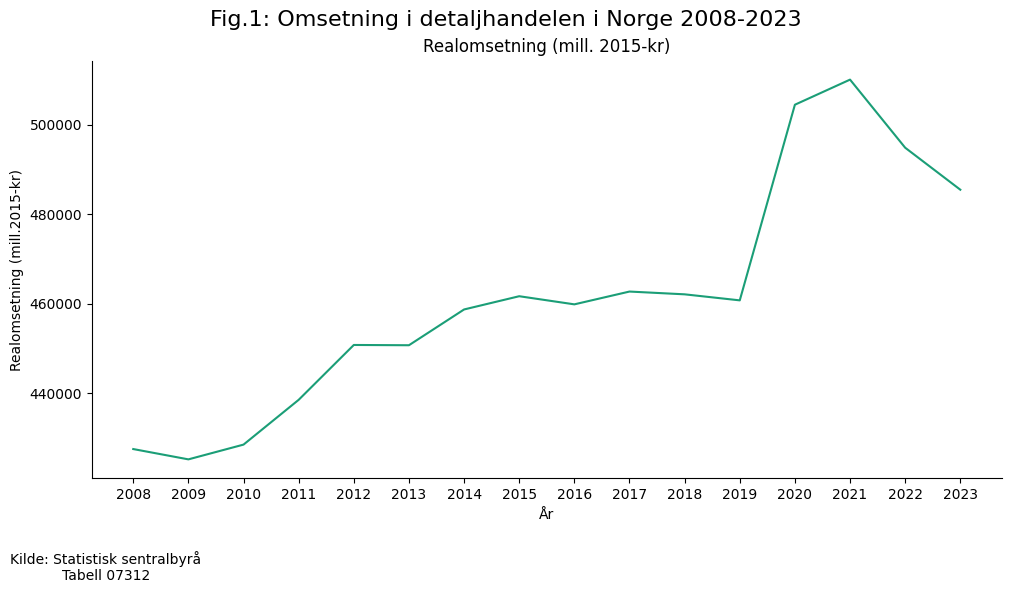

In [19]:
# Henter fram graf fra tidligere kode
plot_series(omsetning_47_df, 'Omsetning i detaljhandelen i Norge 2008-2023',
            title="Fig.1: Omsetning i detaljhandelen i Norge 2008-2023",
            subtitle="Realomsetning (mill. 2015-kr)",
            undertext="Kilde: Statistisk sentralbyrå Tabell 07312")

Fig.1 Utviklingen i realomsetningen i hele detaljhandelen i Norge fra 2008 til 2023.

Grafen viser en stabil vekst i realomsetningen i næringen fra 2009 til 2014, med en utflatning etter det frem til 2019. Deretter ser vi en markant økning i realomsetningen under pandemien, og spesielt fra 2019 til 2021. Dette kan blandt annet skyldes stengte grenser som reduserer grensehandel, samt at folk ikke hadde mulighet til å bruke pengene sine på reiser eller opplevelser som frigjorde midler til å brukes på detaljvarer.
Vi ser at etter en topp i 2021 er det en nedgang i omsetningen som kan tyde på at folk går tilbake til sine normale forbruksmønstre og for eksempel gjennopptar grensehandlingen.

### Sysselsetting i detaljhandelen

In [20]:
# Henter fram graf fra tidligere kode
create_pie_charts(df_retail, df_norway, selected_years)

Fig.2 Sysselsettingen i detaljhnadelen og resten av Norge 2017 og 2022

Grafen viser forskjellen i sysselsetttingen i detaljnæringen mellom 2017 og 2022 sett opp mot sysselsettingen i andre næringer i Norge. Vi ser at det har vært en nedgang på 2,9% i detaljnæringen. Dette kan ha flere grunner, noen av dem pandemirelaterte da detaljhandelen ofte inkluderer direkte kundebehandling som da ble umulig eller svært vanskelig under regjeringens koronatiltak.

Andre potensielle grunner kan være at hele næringen har en gradvis dreining mot netthandel som reduserer behovet for ansatte, eller økt automatisering som for eksempel selvbetjeningskasser.

## iiiA) Velg ut noen produkter og vis hvordan omsetning av disse har utviklet seg over tid.

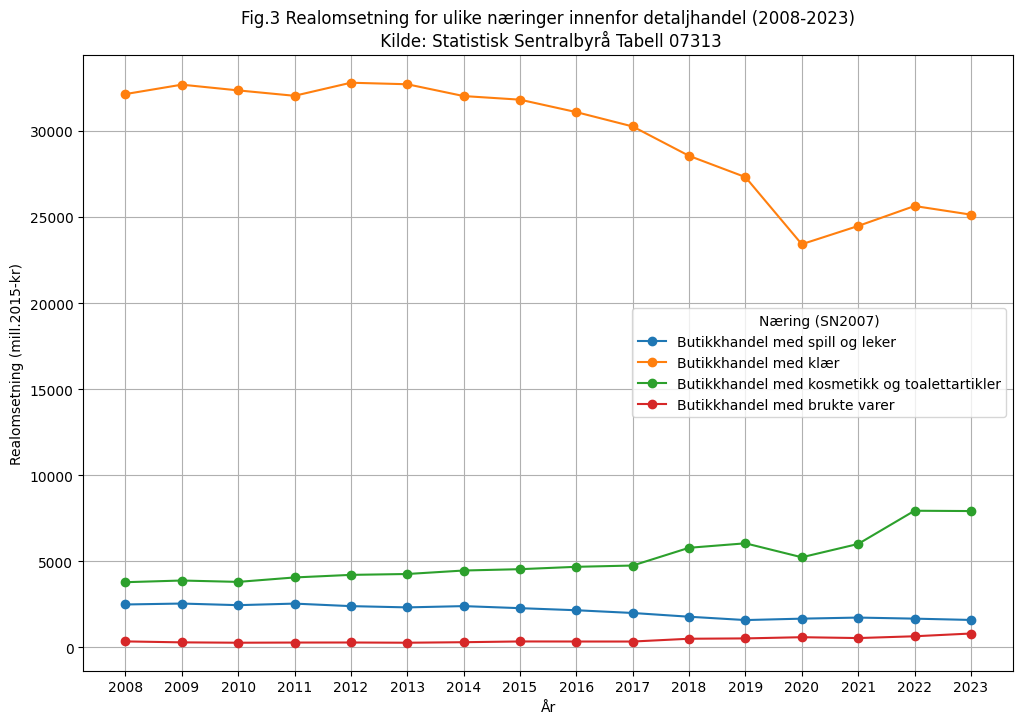

In [21]:
# Henter fram graf fra tidligere kode
plot_multiple_series(Omsetning_07313, industries,
                     title="Fig.3 Realomsetning for ulike næringer innenfor detaljhandel (2008-2023)\n Kilde: Statistisk Sentralbyrå Tabell 07313",
                     xlabel="År",
                     ylabel="Realomsetning (mill.2015-kr)",
                     legend_title="Næring (SN2007)")

Figur 3 Viser realomsetning for ulike næringer under detaljhandel fra 2008 til 2023, basert på data fra Statistisk Sentralbyrå Tabell 07313. Grafen viser realomsetning (målt i millioner kroner, 2015=100) for fire forskjellige varegrupper:
- Butikkhandel med spill og leker (blå linje)
    - Realomsetningen har vært ganske stabil med noen små svingninger, men ingen klare oppad- eller nedadgående trender. Dette blandt annet tilskrives digitalisering: Overgangen til digitale spill kan ha påvirket salg av fysiske spill og leker, men samtidig har tradisjonelle leker fortsatt en stabil etterspørsel.

- Butikkhandel med klær (oransje linje)
    - Denne viser en relativt stabil omsetning fra 2008 til 2019, med en gradvis nedgang etter 2019. Dette kan tilskrives flere faktorer:
        - Økt netthandel: Økende preferanse for å kjøpe klær på nett har redusert omsetningen i fysiske butikker.
        - Covid-19-pandemien: Restriksjoner og endringer i forbrukeratferd under pandemien har påvirket klesbutikker negativt.
        - Økt konkurranse fra internasjonale butikker (på grunn av økt netthandel).

- Butikkhandel med kosmetikk og toalettartikler (grønn linje)
    - Denne viser en svak økning i realomsetning gjennom perioden. Noen grunner kan være:
        - Økt fokus på personlig pleie: Økt bevissthet rundt skjønnhet og personlig pleie har drevet etterspørselen oppover.
        - "The lipstick effect" som er ideen om at i vanskelige økonomiske tider så vil kvinner gjøre mindre kjøp som kan ha en generelt positiv effekt på hverdagen - som å kjøpe en ny lebestift[source 2].

- Butikkhandel med brukte varer (rød linje)
    - Denne viser en relativt lav, men stabil omsetning:
        - Bærekraftstrender: Økt bevissthet rundt bærekraft og gjenbruk har kanskje ikke helt slått gjennom i form av høy omsetning, men viser stabilitet og en svak økning, men ikke store endringer under/på grunn av COVID.

## iiiB) Vis hvordan netthandelen har utviklet seg over tid, samt hvilken andelen av den totale omsetningen for detaljhandel denne kategorien utgjør.

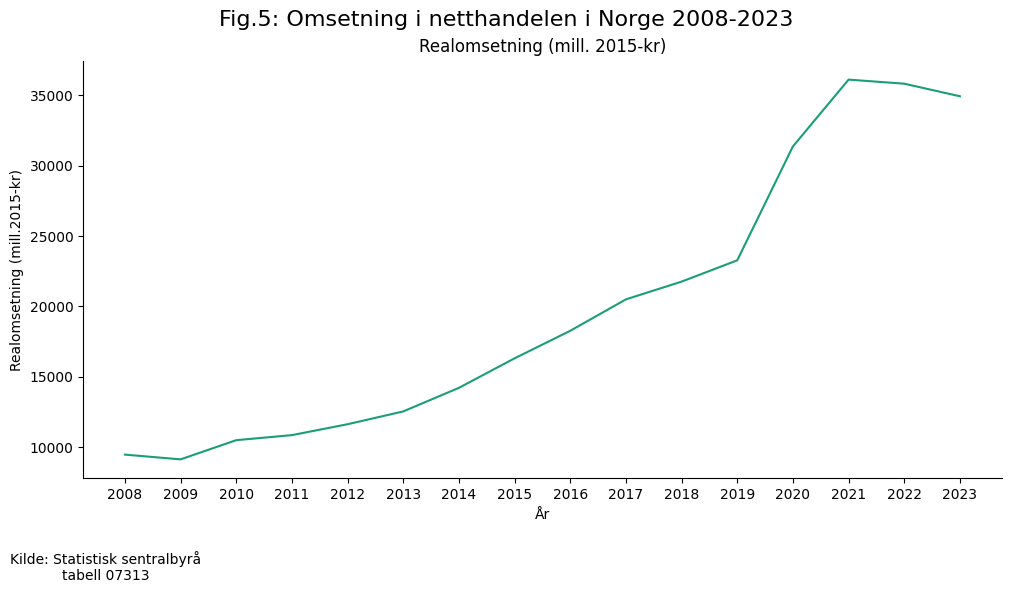

In [22]:
# Henter fram graf fra tidligere kode
plot_series(df_sorted5, 'Omsetning i netthandelen i Norge 2008-2023',
            title="Fig.5: Omsetning i netthandelen i Norge 2008-2023",
            subtitle="Realomsetning (mill. 2015-kr)",
            undertext="Kilde: Statistisk sentralbyrå tabell 07313")

Figur 4 viser utviklingen i realomsetningen for netthandel i Norge fra 2008 til 2023.

Vi ser at netthandel har hatt en kraftig vekst over tid, med en stabil og sterk vekst fram til 2019. Fra 2019 ser vi at veksten virker å nesten dobles frem mot 2021 før den slaker ut noe. Den markente økningen i netthandel under pandemien kan defnitivt begrunnes resttriksjonene på fysisk handel som ble innført og førte til en overgang mot nettshopping. Men det kan være at generelt en økning i bruk av digitale løsninger i hverdagen kan ha gjord digital handel mer tilgjengelig for befolkningsgrupper som ellers har holdt seg til de mer tradisjonelle kanalene (som for eksempel eldre).

Omsetningen etter pandemien er fortsatt betydelig høyere enn pre-pandemiske nivåer, selv med en liten nedgang.. Dette indikerer at netthandel har fått en mer permanent plass i forbrukernes handlemønstre, selv om noe av den eksepsjonelle veksten har normalisert seg.

### Oppsummering

Detaljhandelen i Norge har gjennomgått betydelige endringer fra 2008 til 2023. Mens hele sektoren og netthandelen opplevde en betydelig vekst under pandemien, viser post-pandemiske trender en viss normalisering. Samtidig har flere bransjer hatt utfordringer med å nå tilbake til tidligere omsetningsnivåer, noe som kan være et resultat av endrede forbruksmønstre og vedvarende konkurranse fra netthandel. Disse trendene reflekterer en samfunnsøkonomisk omstilling i detaljhandelen, hvor digitalisering og endrede kjøpsvaner spiller en sentral rolle.

# Oppgave 2 - Produktfunksjon for detaljhandel

I denne oppgaven skal du estimere en produktfunksjon for detaljhandel i Norge. Vi antar at produktfunksjonen tar Cobb-Douglas form:

$$ x = ZN^a K^b \ (1)$$

hvor $x$ er enheter ferdig produkt, $N$ er enheter arbeidskraft, $K$ er enheter kapital og $Z>0$, $a>0$, $b>0$ er konstante tall.

[Tabell 12910, SSB](https://www.ssb.no/statbank/table/12910/) inneholder data etter næring på blant annet Produksjonsverdi, Lønnskostnader og Bruttoinvesteringer (alle i mill NOK), bruk disse til å henholdsvis beregne K, N og x for detlajhandelen i Norge.

## i) Estimer Z, a, b og forklar nøye hva hvert tall representerer.

En Cobb-Douglas-produksjonsfunksjon er en spesifikk type produksjonsfunksjon som brukes i økonomi for å beskrive forholdet mellom innsatsfaktorer (input) og produksjon (output).

Den kan brukes til å modellere produksjonsprosesser i ulike industrier. Ved å bruke data om output ($y$), arbeidskraft ($N$) og kapital ($K$), (her estimert av tabell 12910 som Produksjonsverdi, Lønnskostnader og Bruttoinvesteringer) kan vi estimere verdiene for konstantene $Z$, $a$ og $b$ for å forstå hvordan endringer i disse vil påvirke produksjonen.

***Fordeler, begrensninger/antakelser ved Cobb-Douglas produktfunksjon***

**Fordeler:**
- Gir innsikt i hvordan ulike innsatsfaktorer påvirker produksjonen.

**Begrensninger/antakelser:**
- Antar konstant skalautbytte over tid og teknologisk utvikling. Det vil si at om det er flere faktorer som spiller inn i produksjonen enn Kapital og Arbeidskraft så vil disse ha en konstant utbytte uavhengig av de andre faktorene.


Av oppgaven får vi at Cobb-Douglas-funksjonen har formen:

$$ Y = Z \cdot N^a \cdot K^b $$

Hvor:
- $ Y $ er produksjonsnivået (output).
- $ Z $ er en konstant som representerer total faktorproduktivitet (TFP), også kjent som teknologi eller effektivitet. Dette er en skalar som påvirker hvor effektivt inputs (N og K) blir omdannet til output.
- $ N $ er mengden arbeidskraft som brukes i produksjonen.
- $ K $ er mengden kapital som brukes i produksjonen.
- $ a $ er outputelastisiteten til arbeidskraft, som indikerer prosentvis endring i output når arbeidskraften øker med 1%, gitt at alle andre faktorer er konstante.
- $ b $ er outputelastisiteten til kapital, som indikerer prosentvis endring i output når kapitalen øker med 1%, gitt at alle andre faktorer er konstante.

For å estimere parameterne $Z$, $a$ og $b$ tar jeg disse stegene:

1. **Logaritmisk transformasjon**:
   Transformerer Cobb-Douglas-funksjonen til en lineær form ved bruk av logaritmer for å kunne bruke lineær regresjon til å estimere parametrene.

   Siden den ordinære produksjonsfunksjonen ser slik ut:

   $$Y = Z \cdot N^a \cdot K^b$$
   
  Blir den logaritmiske formen av Cobb-Douglas-funksjonen slik:

   $$log(Y) = \log(Z) + a \cdot \log(N) + b \cdot \log(K)$$

   Hvor $log(Y)$ er $y$, $log(N)$ er $n$, og $log(K)$ er $k$. Da blir ligningen:

   
   $$y = \log(Z) + a \cdot n + b \cdot k$$
   

2. **Data**:
   Av dataene fra tabell 12910 får vi av oppgaven at:

- $Y$ er totalproduksjonen (Produksjonsverdi),
- $N$ er lønnskostnadene (Lønnskostnader),
- $K$ er bruttoinvesteringene (Bruttoinvesteringer),


3. **Lineær regresjon**:
   Etter å ha konvertert likningen til en lineær likning, og funnet frem tallene jeg skal bruke kjører jeg en multippel lineær regresjonsanalyse for å estimere koeffisientene. Koeffisienten for konstantleddet vil gi $log(Z)$, og koeffisientene for $n$ og $k$ vil gi henholdsvis $a$ og $b$.

In [23]:
# Henter fram informasjon fra tidligere kode
print(model_summary)
print(f"Z: {round(Z, 2)}")
print(f"a: {round(a, 2)}")
print(f"b: {round(b, 2)}")

                            OLS Regression Results                            
Dep. Variable:                  log_x   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     522.2
Date:                Mon, 03 Jun 2024   Prob (F-statistic):           8.16e-38
Time:                        15:59:36   Log-Likelihood:                -27.062
No. Observations:                  61   AIC:                             60.12
Df Residuals:                      58   BIC:                             66.46
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5837      0.290      5.465      0.0

Her får vi at Z er 4.87, a 0.81, og b er 0.15 , når alle er rundet ned til to desimaler.

## Hva menes med skalautbytte, og hvordan kan man avgjøre skalautbytte for en produktfunksjon av type Cobb-Douglas?

Skalautbytte refererer til hvordan endringen i mengden av alle innsatsfaktorer påvirker mengden av output. For en Cobb-Douglas-produksjonsfunksjon avgjør man typen skalautbytte ved å summere eksponentene $a$ og $b$:

- Hvis $a + b = 1$, er det konstant skalautbytte. Dette betyr at en proporsjonal økning i alle innsatsfaktorer fører til en like stor prosentvis økning i output.
- Hvis $a + b > 1$, er det økende skalautbytte. Dette betyr at en proporsjonal økning i alle innsatsfaktorer fører til en større prosentvis økning i output.
- Hvis $a + b < 1$, er det avtakende skalautbytte. Dette betyr at en proporsjonal økning i alle innsatsfaktorer fører til en mindre prosentvis økning i output.

##  Hvilken skalaegenskap har produktfunksjonen for detaljhandel som du har estimert? Hvordan forklarer du dette (dvs er svaret intuitivt rimelig utfra type næring som vanligvis har denne type skalautbytte)?

For å finne skalaegenskapen til denne funksjonen, summerer jeg verdiene for $a$ og $b$:
$$a + b = 0.81 + 0.15 = 0.96$$

Siden $a + b < 1$, er det avtakende skalautbytte. Dette betyr at en proporsjonal økning i både arbeidskraft (N) og kapital (K) vil føre til en mindre enn proporsjonal økning i output.


- Intuisjonen i forhold til detaljnæringen

Detaljhandelnæringen er ofte preget av mange små aktører og høy konkurranse. Avtakende skalautbytte kan reflektere flere realiteter i denne sektoren (spesielt i år 2022):

- **Effektivitetstap ved skalering**: Når selskaper i detaljnæringen vokser, kan de oppleve økte marginalkostnader i form av flere og høyere lønninger, som gjør det vanskelig å holde samme nivå av produktivitet per enhet produsert.
- **Markedsmetning**: Etter hvert som flere ressurser allokeres til detaljhandel, kan markedsmetning føre til mindre avkastning på investert kapital og arbeidskraft, ettersom det blir vanskeligere å finne nye kunder. I tillegg vil en høyere markedsmetning potensielt føre til mer konkurranse om lokaler og arbeidskraft som igjen kan føre til økte kostnader.
- **Covid-19 effekter**: Pandemien har også forstyrret mange aspekter av detaljhandelen, noe som kan ha redusert effektiviteten i sektoren. Spesielt siden vi kun bruker tall fra 2022 til å estimere skalautbyttet. 2022 var fortsatt en tid preget av å ha vært rett etter pandemien.

## Hvilke svakheter har denne analysen?

- **Dataegenskaper**: Dataene er fra 2022, en tid som kan være sterkt affektert av COVID-19 og nedgangskonjunkturen som kom etter.

- **Måleproblemer**: Dataene er en estimering basert på andre faktorer, det er også en ekstrem forenkling.
    
- **Segmentspesifike dynamikker**: Ulike segmenter av detaljhandelsnæringen kan oppleve ulike former for skalautbytte så det er mulig at ved å slå alle under en kam blir det et for generelt overblikk.

- **Valg av funksjon**:En Cobb-Douglas funksjon forutsetter perfekte markeder og ingen eksternaliteter, dette samsvarer ikke med virkeligheten og dermed kan valget av produktfunksjon i seg selv ikke være ideell.

# Oppgave 3

Butikken "Helt midt på treet" er en ganske *gjennomsnittlig* bedrift i en bransje i detaljhandelen. I denne sammenhengen betyr gjennomsnittlig følgende:       

- $Z, a, b$ som du fant i oppgave 2 beskriver produktfunksjonen til bedriften.
- Én timeslønn i denne bedriften tilsvarer gjennomsnittet for detaljhandelen.
- På kort sikt har bedriften kapitalutgifter som tilsvarer gjennomsnittet for detaljhandelen.

I praksis betyr dette at du kan bruke dine estimat på $Z, a, b$ (ta 2 desimalplasser) som bedriftens produktfunksjon i (1), at timelønna er 287 kr i 2022, og at kapitalutgiften er gjennomsnittet av det som du har i datasettet (som du må finne). (Tabell 11421, SSB gir gjennomsnittlig månedslønn i 2022 for en ansatt i gruppe 47 Detaljhandel som 41 290 kr. SSB sier videre at en ansatt i full stilling arbeider 230 dager i året, som utgjør 19.2 dager i snitt pr måned, eller ($19.2*7.5=$) 144 timer pr måned).          

Vi går ut fra at "Helt midt på treet" har følgende produktfunksjon:


\begin{equation}
   y = ZL^aK_0^{b}\;\;(2)
\end{equation}

Her er $y$ antall enheter produsert, $L$ antall timer arbeidskraft, mens $K_0$ er kapitalutgiften til bedriften i mill. NOK. (Legg merke til at vi nå blander fysiske og monetære enheter).       

## i) Skriv et uttrykk for bedriftens variable og totale kostnader på kort sikt som en funksjon av mengde produsert (y)

Først må jeg finne $K_0$ ved å finne den gjennomsnittelige verdien for "Bruttoinvesteringer" som her brukes som en verdi på innsattsfaktoren Kapital (K).

In [24]:
# Henter fram informasjon fra tidligere kode
print(f"Ved å finne gjennomsnittet av alle Bruttoinvesteringer i 2022 får vi at K0 er: {K0}")

Ved å finne gjennomsnittet av alle Bruttoinvesteringer i 2022 får vi at K0 er: 271.27


Finn bedriftens variable kostnader og totale kostnader på kort sikt som en funksjon av mengde produsert $y$:

1. Finn uttrykk for arbeidskraft $L$ som en funksjon av produksjon $y$.
Produksjonsfunksjonen er gitt som:
$$y = Z \cdot L^a \cdot K_0^b$$

Vi vet at:
- $ Z = 4.87 $
- $ a = 0.81 $
- $ b = 0.15 $
- $ w = 287  $
- $ K_0 = 271$

Dermed blir $L$ som en funksjon av $y$:
$y = 4.87 \cdot L^{0.81} \cdot (271)^{0.15}$

Konstantene blir da:
$$(271)^{0.15} \approx 1.926 $$
$$ y = 4.87 \cdot 1.926 \cdot L^{0.81} $$
$$y \approx 9.374 \cdot L^{0.81}$$

Løser for $L$:
$$L^{0.81} = \frac{y}{9.374} $$
$$L = \left( \frac{y}{9.374} \right)^{\frac{1}{0.81}}$$


2. Uttrykk for variable kostnader (VC)
De variable kostnadene er lønnskostnadene, eller produktet av lønnen per time $w$ og mengden arbeidskraft $L$.

Lønnen per time er:
$w = 287 \, \text{NOK per time} $

Da blir de variable kostnadene som en funksjon av produksjon $y$:
$$VC(y) = w \cdot L $$
$$VC(y) = 287 \cdot \left( \frac{y}{9.374} \right)^{\frac{1}{0.81}}$$

3. Totale kostnader (TC)
De totale kostnadene på kort sikt inkluderer de faste kostnadene og de variable kostnadene. Vi antar at kapitalen er en fast kostnad som ikke endres med produksjonsnivået.

De faste kostnadene (FC) er da bare kostnadene til kapital $K_0$:

$$FC = K_0 \cdot 10^6 \, \text{NOK}$$
$$FC = 271 \, \text{millioner NOK} = 271 \cdot 10^6 \, \text{NOK} = 2710000 \, \text{NOK} $$

De totale kostnadene (TC) er da summen av de variable og faste kostnadene:
$$TC(y) = VC(y) + FC $$
$$TC(y) = 287 \cdot \left( \frac{y}{9.374} \right)^{\frac{1}{0.81}} + 2519000 $$

4. Oppsummering
Uttrykk for bedriftens variable kostnader som en funksjon av mengde produsert $(y)$:
$$VC(y) = 287 \cdot \left( \frac{y}{5.683} \right)^{\frac{1}{0.81}} $$

Uttrykk for bedriftens totale kostnader som en funksjon av mengde produsert $(y)$:
$$TC(y) = 287 \cdot \left( \frac{y}{5.683} \right)^{\frac{1}{0.81}} + 2519000 $$

## ii)Finn uttrykk for bedriftens grensekostnad og gjennomsnittskostnad (total og variabel)

Vi vet fra forrige deloppgave at uttrykket for arbeidskraft $L$ som en funksjon av produksjon $y$ er:

$$ L = \left( \frac{y}{9.374} \right)^{\frac{1}{0.81}} $$

1. Finn grensekostnad (MC)

Grensekostnadene (MC) er den deriverte av de totale kostnadene (TC) med hensyn til produksjonsnivået $y$:

$$MC(y) = \frac{dTC(y)}{dy} $$

Beregner den deriverte:
$$ VC(y) = 287 \cdot \left( \frac{y}{9.374} \right)^{\frac{1}{0.81}} $$
$$VC(y) = 287 \cdot \left( \frac{y}{9.374} \right)^{1.2346} $$


Deriverer så VC(y):
$$ MC(y) = \frac{d}{dy} \left[ 287 \cdot \left( \frac{y}{9.374} \right)^{1.2346} \right]  $$

$$ MC(y) = 287 \cdot 1.2346 \cdot \left( \frac{y}{9.374} \right)^{0.2346} \cdot \frac{1}{9.374}$$

$$ MC(y) = 287 \cdot 1.2346 \cdot 9.374^{-1.2346} \cdot y^{0.2346} $$

2. Finn gjennomsnittskostnad (AC)

Gjennomsnittskostnadene (AC) er de totale kostnadene (TC) delt på mengde produsert $y$:

$$ AC(y) = \frac{TC(y)}{y} $$

Beregner uttrykket for $( TC(y) )$:
$$ TC(y) = 287 \cdot \left( \frac{y}{9.374} \right)^{1.2346} + 271,000,000 $$

Da blir:
$$ AC(y) = \frac{287 \cdot \left( \frac{y}{9.374} \right)^{1.2346} + 271,000,000}{y} $$

Gjennomsnittlig variable kostnader (AVC):
$$ AVC(y) = \frac{VC(y)}{y} $$
$$AVC(y) = \frac{287 \cdot \left( \frac{y}{9.374} \right)^{1.2346}}{y} $$

### Oppsummering

- **Grensekostnad (MC)**:
$ MC(y) = 287 \cdot 1.2346 \cdot 9.374^{-1.2346} \cdot y^{0.2346}  $

- **Gjennomsnittskostnad (AC)**:
$ AC(y) = \frac{287 \cdot \left( \frac{y}{9.374} \right)^{1.2346} + 271,000,000}{y} $

- **Gjennomsnittlig variable kostnader (AVC)**:
$ AVC(y) = \frac{287 \cdot \left( \frac{y}{9.374} \right)^{1.2346}}{y}  $

## iii) Bruk ditt svar til ii) for å tegne bedriftens tilbudskurve i en figur. Forklar figuren nøye.

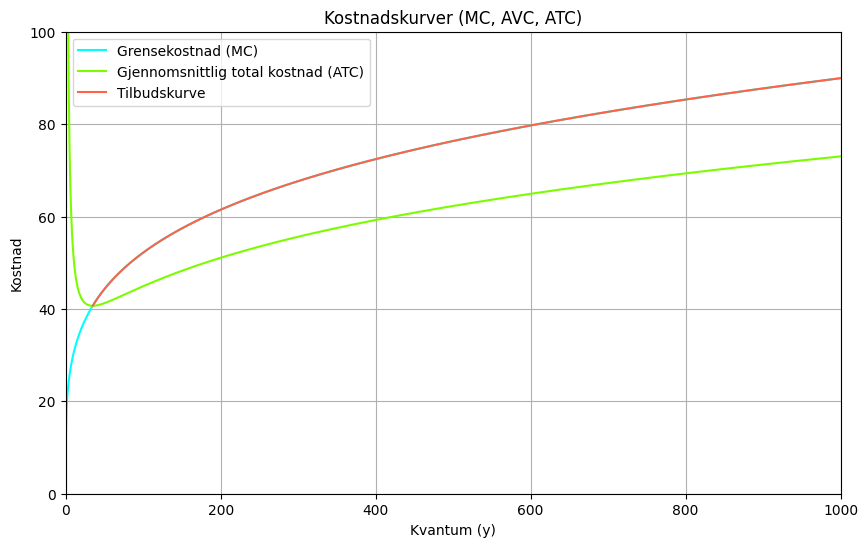

In [25]:
# Henter fram informasjon fra tidligere kode
plot_cost_curves_før(a, Z, K0, b)

Figuren viser tre kurver:

- **Grensekostnadene (MC)**: som representerer bedriftens grensekostnader. Den forteller oss hvor mye det koster bedriften å produsere en ekstra enhet av hva nå enn de produserer. Ofte er det ikke lønnsomt å bare produsere én enhet siden det inngår faste og variable kostnader som synker per ekstra enhet produsert frem til det når et optimum hvor da prisen blir dyerer igjen per enhet produert.

- **Gjennomsnittelig total kostnad (AVC)**: Som forteller oss hvor mye det koster bedriften å produsere en ekstra enhet i tillegg til de totale kostnadene.

- **Tilbudskurven**: Området på MC-kurven over AVC. Dette området denoterer hvor mange enheter og til hvilken pris det er lønnsomt for bedriften å produsere.

## Anta at lønnsoppgjøret gir arbeidere i "Helt midt på treet" en lønnsøkning på 5%. Vis hvordan dette påvirker bedriftens tilbud, og forklar intuisjonen bak endringen.

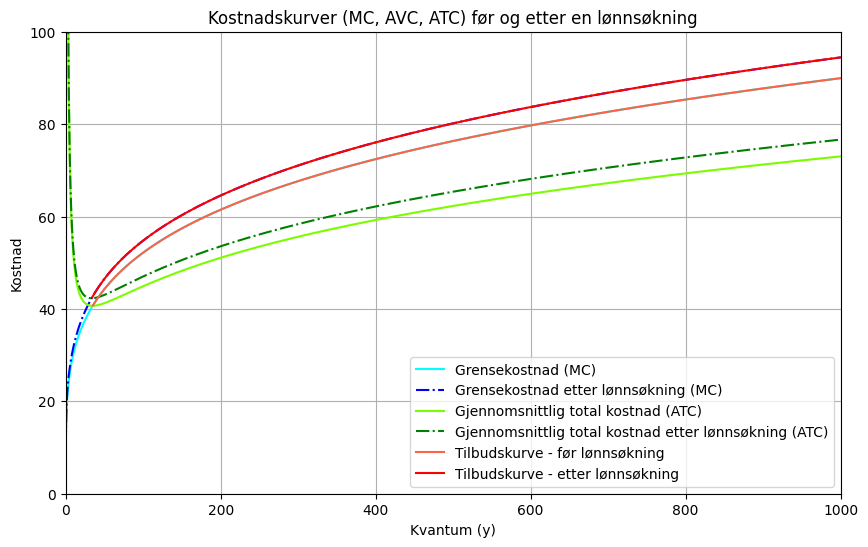

In [26]:
# Henter fram informasjon fra tidligere kode
plot_cost_curves_etter(a, Z, K0, b)

Intuisjonen bak endringen

- **Økte kostnader**: En lønnsøkning på 5% øker de variable kostnadene til bedriften fordi arbeidskraft blir dyrere.
- **Grensekostnadskurve (MC)**: I grafen skifter MC-kurven oppover og mot venstre fordi det koster mer å produsere hver ekstra enhet.
- **Tilbudskurve**: Tilbudskurven, som er delen av MC-kurven over Gjennomsnittelige Totale Kostnader (AVC), skifter også oppover. Dette betyr at for en gitt produksjonsmengde, vil bedriften kreve en høyere pris for å dekke de økte kostnadene.
- **Markedseffekter**: På markedet kan dette føre til høyere priser og redusert tilbud - som igjen betyr en potensiell nedgang i den samfunnsøkonomiske velferden da det da blir konsumenter som blir priset ut av varen.


# 4. Appendix

## Kilder

Kode adaptert fra: derekjclark. sok-1006_notater. GitHub. https://github.com/uit-sok-1006-v24/sok-1006_notater

 Menon Economics. (2020). Covid-19-situasjonens konsekvenser for industri, varehandel og reiseliv. Hentet fra https://www.menon.no/wp-content/uploads/2020-61-Covid19-situasjonens-konsekvenser-for-industri-varehandel-og-reiseliv-1.pdf

2: Danziger, P. (2022, June 1). With Inflation Rising, The Lipstick Effect Kicks In And Lipstick Sales Rise. Forbes. https://www.forbes.com/sites/pamdanziger/2022/06/01/with-inflation-rising-the-lipstick-effect-kicks-in-and-lipstick-sales-rise/

## KI

Jeg har brukt KI til å lage de fleste grafer, og til å formattere Kildehenvisninger.
Her er en lenke til eksempel på hva og hvordan jeg har brukt KI:
https://chatgpt.com/share/fb97781e-747f-40d5-80a9-e0e466d8b977